# 과제) Cifar10 data를 사용한 모델 성능 향상시키기

<font color = "#CC3D3D"><p>
- [과제코드 작성하기](#과제코드-작성하기)

## Module import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
from torchvision import transforms, datasets
import torch.nn.init as init
import random

## Device Checking

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version: ', torch.__version__, 'DEVICE:', DEVICE)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(777)

Using PyTorch version:  1.8.0 DEVICE: cuda


## Data Downloading

#### Hyper parameter

In [5]:
BATCH_SIZE = 32
EPOCHS = 10
Learning_Rate = 0.01
drop_prob = 0.5

In [6]:
standardization = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4913, 0.4821, 0.4465], std = [0.2470, 0.2434, 0.2615])

])

In [7]:
train_set = torchvision.datasets.CIFAR10(root='./cifar10',
                                        train=True, 
                                        download=True, 
                                        transform = standardization)

test_set = torchvision.datasets.CIFAR10(root='./cifar10', 
                                       train=False, 
                                       download=True, 
                                       transform = standardization)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./cifar10\cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


#### 데이터가 잘 다운되었는지 확인

In [8]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
    
print('\n')
print('train_set:', train_set)
print('\n')
print('test_set:', test_set)

# 이자료는 MNIST와 다르게 Channel이 3개임을 알 수 있다. (R, G, B Channels)

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


train_set: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4913, 0.4821, 0.4465], std=[0.247, 0.2434, 0.2615])
           )


test_set: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4913, 0.4821, 0.4465], std=[0.247, 0.2434, 0.2615])
           )


#### 실제로 data를 확인해보기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


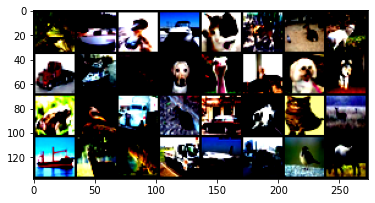

 frog  ship  bird  ship


In [9]:
def imshow(img):  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Build Basic Model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
                    nn.Linear(3 * 32 * 32, 512),
                    nn.Sigmoid())
        
        self.layer2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.Sigmoid())
        
        self.layer3 = nn.Sequential(
                    nn.Linear(256, 10),
                    nn.LogSoftmax(dim = 1))
        
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [9]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = Learning_Rate)  
criterion = nn.CrossEntropyLoss()  

print(model)

Net(
  (layer1): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): Sigmoid()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


## Model Train, Test

In [16]:
def train(model, train_loader, optimizer, log_interval):
    model.train()            # train을 하겠다고 선언해준다. 
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()
        
        output = model(image)
        loss = criterion(output, label)
    
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [17]:
def evaluate(model, test_loader):
    model.eval()                      # 평가를 한다고 선언해준다. 
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): 
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 학습, 테스트 진행

In [12]:
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.340000
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.282292
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 2.323937
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 2.307219
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 2.285362
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 2.301730
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.284976
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 2.287122

[EPOCH: 1], 	Test Loss: 0.0718, 	Test Accuracy: 15.20 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 2.283570
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 2.284820
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 2.295300
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 2.294395
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 2.266618
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 2.271042
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 2.294543
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 2.241453

[EPOCH: 2], 	Test Loss: 0.0706, 	Test Accuracy: 17.26 % 

# 과제코드 작성하기

### 배운 5가지 알고리즘을 모두 활용해 Test Accuracy를 올리시오.

In [10]:
BATCH_SIZE = 64
EPOCHS = 10
Learning_Rate = 0.01
drop_prob = 0.3

In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [12]:
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [13]:
# code here
## 같은 코드이지만 다른 스타일로 nn.Sequential을 사용하여 짤 수 있다.

class Net_al(nn.Module):
    def __init__(self):
        super(Net_al, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.BatchNorm1d(1024),
            Mish(),
            nn.Dropout(p = drop_prob)
        )
      
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            Mish(),
            nn.Dropout(p = drop_prob)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            Mish(),
            nn.Dropout(p = drop_prob)
        )
        
       # self.layer5 = nn.Sequential(
        #    nn.Linear(256, 128),
         #   nn.BatchNorm1d(128),
         #   Mish(),
        #    nn.Dropout(p = drop_prob)
       # )
        
        self.layer6 = nn.Sequential(
            nn.Linear(256, 10),
            nn.LogSoftmax(dim = 1)
        )
        
        
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
      #  x = self.layer4(x)
     #   x = self.layer5(x)
        x = self.layer6(x)
        return x

In [14]:
# He initialization
def weight_init(m):
    if isinstance(m, nn.Linear):                          # m이 nn.Linear이라면 실행해줌
        init.kaiming_uniform_(m.weight.data)            # HE initialization을 적용하는 코드

model_al = Net_al().to(DEVICE)
model_al.apply(weight_init)                                                 # apply 함수를 통해 model에 가중치 초기화함수 적용
#optimizer = RAdam(model_al.parameters(), lr = Learning_Rate)               # 옵티마이저1
optimizer = torch.optim.Adamax(model_al.parameters(), lr = Learning_Rate)   # 옵티마이저2 

criterion = nn.CrossEntropyLoss()                                          # 비용함수 

print(model_al)

Net_al(
  (layer1): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): Dropout(p=0.3, inplace=False)
  )
  (layer6): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


In [18]:
train_loss_item_al = []
test_loss_item_al = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model_al, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model_al, test_loader)
    train_loss_item_al.append(train_loss)
    test_loss_item_al.append(test_loss)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))


# 64 - Adamax - 0.01 - mish - 0.3 - 10 : 56.89
# 64 - Adamax - 0.01 - mish - 0.3 - 10 : 56.89
# 56.88 / 

<ipython-input-12-37dd77e3a775>:9: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.596777
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.683484
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.678872
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.774112

[EPOCH: 1], 	Test Loss: 0.0240, 	Test Accuracy: 45.46 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.802967
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.503605
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.739144
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.472763

[EPOCH: 2], 	Test Loss: 0.0224, 	Test Accuracy: 48.86 % 

Train Epoch: 3 [0/50000 (0%)]	Train Loss: 1.544734
Train Epoch: 3 [12800/50000 (26%)]	Train Loss: 1.536254
Train Epoch: 3 [25600/50000 (51%)]	Train Loss: 1.583714
Train Epoch: 3 [38400/50000 (77%)]	Train Loss: 1.442070

[EPOCH: 3], 	Test Loss: 0.0216, 	Test Accuracy: 49.76 % 

Train Epoch: 4 [0/50000 (0%)]	Train Loss: 1.224954
Train Epoch: 4 [12800/50000 (26%)]	Train Loss: 1.477067
Train Epoch: 4 [25600/50000 (51%)]	Train Loss: 1.319779
Tra

## CNN 적용

In [86]:
BATCH_SIZE = 128
EPOCHS = 10
Learning_Rate = 0.01
drop_prob = 0.3

In [89]:
# code here
## 같은 코드이지만 다른 스타일로 nn.Sequential을 사용하여 짤 수 있다.

drop_prob = 0.3           # drop_prob는 hyper parameter이므로 미리 설정한다.
class Net_al(nn.Module):
    def __init__(self):
        super(Net_al, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            Mish(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        
        self.fc1 = nn.Linear(3*3*256, 256, bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)

        self.layer5 = nn.Sequential(
            self.fc1,
            nn.BatchNorm1d(256),
            Mish(),
            nn.Dropout(p = drop_prob)
        )
        
        # L5 Final FC 512 inputs -> 10 outputs
        self.fc2 = nn.Linear(256, 10, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        
        self.layer6 = nn.Sequential(
            self.fc2,
            nn.LogSoftmax(dim=1)
        )
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer5(out)
        out = self.layer6(out)
        return out

In [90]:
# He initialization
def weight_init(m):
    if isinstance(m, nn.Linear):                          # m이 nn.Linear이라면 실행해줌
        init.kaiming_uniform_(m.weight.data)            # HE initialization을 적용하는 코드

model_al = Net_al().to(DEVICE)
model_al.apply(weight_init)                                                 # apply 함수를 통해 model에 가중치 초기화함수 적용
optimizer = torch.optim.Adam(model_al.parameters(), lr = Learning_Rate)    # 옵티마이저 
criterion = nn.CrossEntropyLoss()                                          # 비용함수 

print(model_al)

Net_al(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Batch

In [92]:
train_loss_item_al = []
test_loss_item_al = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model_al, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model_al, test_loader)
    train_loss_item_al.append(train_loss)
    test_loss_item_al.append(test_loss)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))
    
# 78.64
# 78.84

<ipython-input-12-37dd77e3a775>:9: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 0.126381
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 0.104113
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 0.207518
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.286908

[EPOCH: 1], 	Test Loss: 0.0165, 	Test Accuracy: 76.97 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.058691
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.111682
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.064466
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.147541


KeyboardInterrupt: 